# Generating an STL-file for 3D-printing in Python
In the following documentation I will generate a 3D-object.  
As an example I'll make a bulgy/wavy flower vase, looking like this:  
<img src="3d_print.png" alt="A 3D printed flower vase" width="500"/>

And the corresponding matplotlib generated figure looks like this:  
![Plot of a vase in 3D](vase.png "vase to be converted to a STL file")

The output of this iPython Notebook is a STL file which can be imported to a slicer software (e.g. flashprint) which slices it for your specific 3D-printer.

My steps for creating this vase were the following analogy:
1. Create a cone from $z = z_{min}$ to $z = z_{max}$ where $r = a * z + b$.
2. Add waves to the radius by making it dependent on both the angle and z, creating an irregular shape.

First, let us import all the modules we need:
1. axes3d from mpl_toolkits (part of matplotlib) to visualize
2. pyplot from matplotlib also to visualize
3. measure from skimage to generate the vertices and faces from the marching cube algorithm, in order to generate the STL file.
4. mesh from stl to generate the 3D object from the vertices and faces
5. numpy because it is numeric python we are doing here
6. time and datetime is not necessary but it might be useful to predict/track the time consumption if you sett a really high resolution

In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from skimage import measure
from stl import mesh
import numpy as np
import datetime
import time
pi = np.pi

Set up the boundaries for our 3D object.  
I let z go from $0.6\pi$ to $2\pi$  
$0.6\pi$ is because I wan the initial radius at the bottom to be sufficient large and the cos-terms to be small  
$2\pi$ because I want the cos-terms to be at it max giving the vase a concave shape at the top and that the max radius is also at the top.  
I use polar coordinates therefore I define a $\theta$ from $0$ to $2\pi$, later you will se that I set x = $r*cos(\theta)$ and $y = r*sin(\theta)$

mesh_resolution is yours to play with. If you set it larger than 1000 the scipt might take hours to complete and the resulting STL file might be close to 1GiB
wall_thickness is also yours to play with. It increases the wall_thickness of the object, which makes it surdier and heavier.

In [2]:
Zmin = 0.6*pi
Zmax = 2*pi
delta = (Zmax - Zmin)/2
mesh_resolution = 400
# Set up the grid in polar coordinates
x = y = np.linspace(-2, 2, mesh_resolution)
theta = np.linspace(0, 2*pi, mesh_resolution)
z = np.linspace(Zmin,Zmax,mesh_resolution)
wall_thickness = 0.012 / (x.max() - x.min()) # Wall thickness of object.
floor_thickness = 3 # Number of vertical layers that should be solid to create a sturdy bottom.

This is where the art happens.
The heart of the design is how the radius of the cone depends on both the hight and angle of the vase.
By making $r$ dependent on $z$ it changes the steepness of the cone.
The transformation from a cone to a vase is done by adding three effects:
1. Adding radial waves, i.e. that $r$ depends on $\theta$. The vase will brake and become discontinous if $r(0) != r(2\pi)$, the circle has to connect back onto itself. Further down there is a check to ensure just this.
2. Adding vertical waves, i.e. that $r$ depends on $z$. Here there are no restrictions since the top and bottom is not connected.
3. Adding twising waves, i.e. that $r$ depends on a combination of $\theta$ and $z$. Agin it is important that the radial component is continous. That is $r(\theta=0, :) != r(\theta=2\pi, :)$.

In [3]:
# The art happens here!
def Radius(ang,z):
    R = 0
    R += z/8 + 0.3 # inclination
    R += 0.25*np.cos(ang/2)**2 + 0.3*np.sin(2.5*ang+pi/10)**2 + 0.05*np.sin(3*ang-pi/3) + 0.07*np.cos(6*ang) # Radial waves
    R += 0.05*np.cos(z) + 0.10*np.cos(2*z-pi/10)**2 + 0.09*np.cos(3*z) + 0.07*np.cos(3.5*z)**2 # Vertical waves
    R += 0.15*np.cos(3*(z+ang)) + 0.15*np.sin(-1*(2*z+2*ang)) # twisting waves
    return R

# Plotting the object
First we generate two 2D-array of all combinations of $\theta$ and $z$. $T$ and $Z$ will have a resolution of [mesh_resolution, mesh_resolution]

Then we compute the 2D-array of all radii given $T$ and $Z$.
Then the 2D-arrays of $X$ and $Y$ are just the $\cos$ and $\sin$ of $R$, respectively.

A check follows to ensure $R(0) = R(2\pi)$

And then the figure is plotted and saved as PNG.

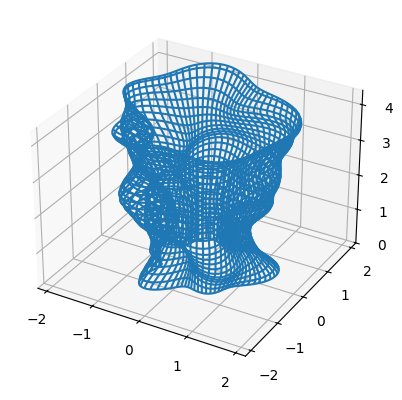

In [4]:
T, Z = np.meshgrid(theta, z)

R = Radius(T,Z)
# Then calculate X and Y
X = R * np.cos(T)
Y = R * np.sin(T)
Z[Z < Zmin] = np.nan
Z[Z > Zmax] = np.nan
Z -= Zmin # I want the bottom plane to be at Z=0

check = R[:,0] - R[:,-1] #Checking that R(0) = R(2π)
if np.any(np.abs(check) > 0.000000001):
    print(f"Discontinuity detected!, max: {np.max(check):.1f}, min: {np.min(check):.1f}")
    plt.plot(X[0,:], Y[0,:])

# Plot
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_wireframe(X, Y, Z, rcount=30, ccount=80)
ax.set_xlim(-delta, delta)
ax.set_ylim(-delta, delta)
ax.set_zlim(0,2*delta)
plt.savefig("vase.png")
plt.show()
plt.close(fig)

# Method 1 below generates the mask for the 3D-object.
This is a huge triple for loop running through all of $Z$ and some of $X$ and $Y$ to generate the object with some wall_thickness.  
Not all $X$ and $Y$ has to be looked at because we know that $d = \sqrt{(x^2 + y^2)} > r$  if $|x| > r$ or $|y| > r$.  
The code `filter = (x > -max_R) & (x < max_R)` and `filter = (y > -max_R) & (y < max_R)` ensures to generate a subset of x and y to work within.  
Also if $d = \sqrt{(x^2 + y^2) > r}$ if $x > 0$ and $y > 0$ we know that the rest will be empty, so we can break the inner most loop.

Note that the layer $Z=1$ is solid if the distance is less that the outer radius, this is to close of the bottom of the vase. If the final 3D-printed object has a too thin bottom, increase this to a range.

There is an `estimated_duration` variable which is computer specific. I ran this notebook in Jupyter Notebook inside a Docker container which used $1608s$ to compute a $700^3$ mask.

I my setup the Kernel breaks around mesh_resolution = 800.

In [5]:
method = 1
# This code is perfectly functional; however it has O(N**3) so it quickly spends a lot time; however this can handle larger mesh_resolution than method 2
def inner_loop(k, zv, j, yv):
    filter = (x > -max_R) & (x < max_R)
    indices_x = np.where(filter)[0]
    for i in indices_x:
        xv = x[i]
        ang = np.arctan2(yv, xv)
        radius = Radius(ang, zv)
        vector_length = np.sqrt(xv**2 + yv**2)
        if 0 < k <= floor_thickness and vector_length <= radius + wall_thickness:
            # Make the bottom layer solid (NB! from Z = 1, not 0 because the top and bottom plane is all 0's
            mask[i,j,k] = 1
        elif np.abs(vector_length - radius) <= wall_thickness:
            # print(f"Radius: {radius:.2f}, x: {xv:.2f}, y: {yv:.2f}, vector length: {vector_length:.2f}")
            mask[i,j,k] = 1
        elif vector_length > (radius + 4*wall_thickness) and xv > 0 and yv > 0:
            return

est_duration = int(mesh_resolution**3/700**3*1608)
print(f"With a mesh size of {mesh_resolution**3}, this command might take {str(datetime.timedelta(seconds=est_duration))}")
start = time.time()
mask = np.zeros([mesh_resolution, mesh_resolution, mesh_resolution])
print(f"Mesh shape: {mask.shape}")
for k, zv in enumerate(z[1:-2]): # want bottom and top layer to be all zeros because of the marching cube algorithm
    max_R = np.max(Radius(theta,zv)) + wall_thickness
    filter = (y > -max_R) & (y < max_R)
    indices_y = np.where(filter)[0]
    for j in indices_y:
        inner_loop(k, zv, j, y[j])
duration = int(time.time() - start)
print(f"This triple for-loop of {mesh_resolution**3} computations took {str(datetime.timedelta(seconds=duration))} seconds")
print(f"There are {int(np.sum(mask))} valid points")

With a mesh size of 64000000, this command might take 0:05:00
Mesh shape: (400, 400, 400)
This tripple for-loop of 64000000 computations took 0:04:29 seconds
There are 265126 valid points


# Method 2 below generates the mask for the 3D-object in a much faster way!
Behold no triple nested for loop.

Fist a outer radius is generated by adding the wall_thickness.
A 3D-array meshgrid (voxel grid) is generated within the domain of all possible $X$, $Y$ (given by the largest radius component) and $Z$

The inner and outer radius for each point in the 3D grid is compared to the distance from origin for all points. Generating two binary results; first is all `True` if the distance is less than outer radius; second is all `True` if the distance is less than the inner radius. Taking the intersection of the outer mask with the complement of the inner mask gives a mask with `True` values between the outer and inner radii.

Note that the layer $Z=1$ is solid if the distance is less that the outer radius, this is to close of the bottom of the vase. If the final 3D-printed object has a too thin bottom, increase this to a range.

I my setup the Kernel breaks around mesh_resolution = 500. I do not know why this method handles a smaller mesh_resolution than method 1 given that it is so much faster

In the end I plot two coss sections: the bottom of the vase, $Z=1$ and the top $Z=Z_{max}$ (which you can write as -1).

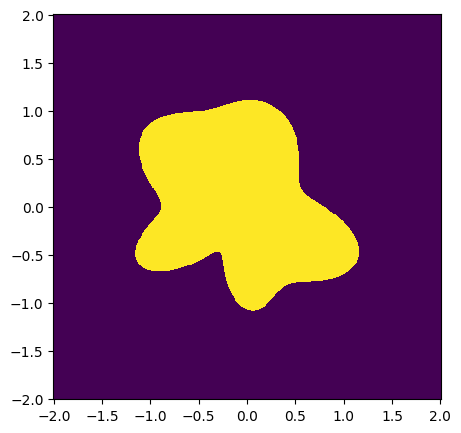

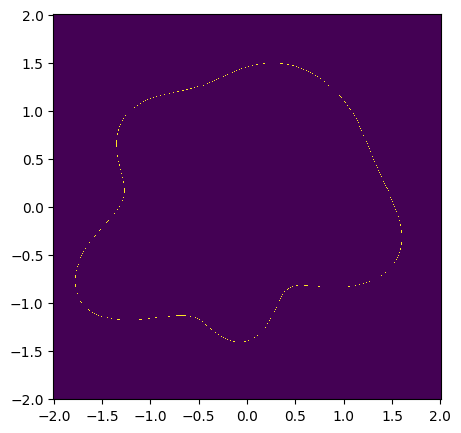

In [6]:
method = 2
# This cell creates the mask faster.
# NB! for mesh_resolution > 500 it will crash!

# Calculate R, X, Y for the inner surface
R_outer = R + wall_thickness
X_outer = R_outer * np.cos(T)
Y_outer = R_outer * np.sin(T)

# Create voxel grid
xv, yv, zv = np.meshgrid(
    np.linspace(X_outer.min(), X_outer.max(), mesh_resolution),
    np.linspace(Y_outer.min(), Y_outer.max(), mesh_resolution),
    np.linspace(Z.min(), Z.max(), mesh_resolution),
    indexing='ij'
)

# Compute distances from the origin for all points in the voxel grid
distances = np.sqrt(xv**2 + yv**2)

# Create masks for the outer and inner surfaces based on the angle and height
T_grid = np.arctan2(yv, xv)  # Angle theta
Z_grid = zv  # Height z

# Calculate corresponding radius for each point in the voxel grid
R_grid = Radius(T_grid, Z_grid)
R_outer_grid = R_grid + wall_thickness

# Create masks based on calculated radii
mask_outer = distances <= R_outer_grid
mask_inner = distances < R_grid

# Fill the voxels between the inner and outer surfaces
mask = mask_outer & ~mask_inner

# Make the bottom layer solid (NB! from Z = 1, not 0 because the top and bottom plane is all 0's
bottom_layer_radius = R_grid[:,:,1:floor_thickness+1]
mask[:, :, 1:floor_thickness+1] = distances[:, :, 1:floor_thickness+1] <= bottom_layer_radius

x2d, y2d = np.meshgrid(x, y)
fig = plt.figure(figsize=(5,5))
plt.pcolormesh(x2d, y2d, mask[:, :, 1])
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(5,5))
plt.pcolormesh(x2d, y2d, mask[:, :, -1])
plt.show()
plt.close(fig)

# Generating the STL file
First thing is to close off the bottom and top layer. It has to be all zeros to ensure the marching cube algorithm works as intended.

vertices and faces is generated from the mask, and the 3d object is initialized as a numpy zero vector with mesh as dtype, before it is constructed from the vertices and faces of the mask.

Finally the STL file is saved with a file name denoting which method was used and the resolution.

In [7]:
# Close off top and bottom layer, or marching cube alg will mess up STL-file.
mask[:, :, 0] = False
mask[:, :, -1] = False
verts, faces, _, _ = measure.marching_cubes(mask, 0)

obj_3d = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    obj_3d.vectors[i] = verts[f]
obj_3d.save(f"3D_vase_res_{mesh_resolution}_method_{method}.stl")